In [4]:
# d for coin futures, f for usd s futures
from datetime import datetime, timedelta
import pandas as pd
import matplotlib.pyplot as plt
import requests as re
import pandas as pd

api = 'https://api.binance.com/api/v3/klines'
g_api_key='eJBYUpKfnUCA5wXDfJTKGPNaOoyLtnXIb9D6GKFbnABLCndVRRYJrdyI9rMi6D54'
g_secret_key='970sbCiGtH1W4rPW56I4MBbD9brKZegyveedljt3U3D5hry7zMbxa4sxacA80kUv'
headers = {"Accept": "application/json"}

epoch = datetime.utcfromtimestamp(0)

def dt_to_ms(dt):
    delta = dt - epoch
    return int(delta.total_seconds() * 1000)

def dt_from_ms(ms):
    return datetime.utcfromtimestamp(ms / 1000.0)

def json_to_df(json):
    df = {'time':[],'open':[],'high':[],'low':[],'close':[],'volume':[]}
    for item in json:
        df['time'].append(dt_from_ms(item[0]))
        df['open'].append(float(item[1]))
        df['high'].append(float(item[2]))
        df['low'].append(float(item[3]))
        df['close'].append(float(item[4]))
        df['volume'].append(float(item[5]))
    return pd.DataFrame(df)

In [11]:
# using binance data
'''
pair = 'ETHUSDT'
interval = '1h'
start_date = '20210401'
end_date = '20210512'
start_year, start_month, start_day = int(start_date[0:4]), int(start_date[4:6]), int(start_date[6:8])
end_year, end_month, end_day = int(end_date[0:4]), int(end_date[4:6]), int(end_date[6:8])
start_date = dt_to_ms(datetime(start_year, start_month, start_day))
end_date = dt_to_ms(datetime(end_year, end_month, end_day))
limit = 1000
url = api + '?symbol='+pair+'&interval='+interval+'&startTime='+str(start_date)+'&limit='+str(limit)
r = re.get(url, headers=headers)
result = r.json()
df = json_to_df(result)
df['return'] = df['close'].pct_change(1)
plt.hist(df['return'].values)
'''

"\npair = 'ETHUSDT'\ninterval = '1h'\nstart_date = '20210401'\nend_date = '20210512'\nstart_year, start_month, start_day = int(start_date[0:4]), int(start_date[4:6]), int(start_date[6:8])\nend_year, end_month, end_day = int(end_date[0:4]), int(end_date[4:6]), int(end_date[6:8])\nstart_date = dt_to_ms(datetime(start_year, start_month, start_day))\nend_date = dt_to_ms(datetime(end_year, end_month, end_day))\nlimit = 1000\nurl = api + '?symbol='+pair+'&interval='+interval+'&startTime='+str(start_date)+'&limit='+str(limit)\nr = re.get(url, headers=headers)\nresult = r.json()\ndf = json_to_df(result)\ndf['return'] = df['close'].pct_change(1)\nplt.hist(df['return'].values)\n"

(array([ 1.,  5.,  4., 10., 25., 68., 69., 36., 12.,  8.]),
 array([-0.04482819, -0.03713898, -0.02944978, -0.02176057, -0.01407136,
        -0.00638215,  0.00130706,  0.00899627,  0.01668548,  0.02437469,
         0.03206389]),
 <BarContainer object of 10 artists>)

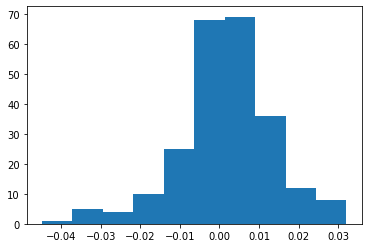

In [16]:
# using uniswap data
tokenA, tokenB = 'WETH','USDT'
url = 'http://3.131.198.9:3003/api/market/pool/backtest/uniswap/'+tokenA+'/'+tokenB+'/10d/1h'
r = re.get(url).json()['data']
df = {'time':[],'close':[]}
for item in r:
    price = float(item[2]) / float(item[3])
    df['time'].append(dt_from_ms(item[-1]))
    df['close'].append(price)
df = pd.DataFrame(df)
df['return'] = df['close'].pct_change(1)
plt.hist(df['return'].values)

<AxesSubplot:>

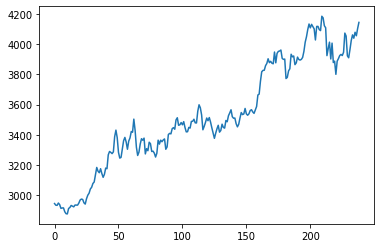

In [17]:
df['close'].plot()

In [18]:
drift = df['return'].dropna().mean()
diffusion = df['return'].dropna().std()
drift * 100
drift=0
diffusion * 100

1.1967139364212929

In [19]:
from numpy.random import normal
import numpy as np
import pandas as pd
import math

def price_simulation(start_value, drift, diffusion, n_periods):
    returns = [1 + (drift + diffusion * normal()) for _ in range(n_periods)]
    prices = [start_value * np.prod(returns[:i]) for i in range(len(returns))]
    return (returns, prices)

def price_simulation_gbm(start_value, drift, diffusion, n_periods):
    prices = []
    for _ in range(n_periods):
        start_value *= math.exp((drift - (diffusion**2) / 2) + diffusion * normal())
        prices.append(start_value)
    return prices

start_value = df.tail(1)['close'].values[0]
n_simulations = 10000
results = []
for _ in range(n_simulations):
    #returns, prices = price_simulation(start_value, drift, diffusion, 168)
    prices = price_simulation_gbm(start_value, drift, diffusion, 24)
    results.append(prices)
terminal_values = [x[-1] for x in results]

(array([  12.,  224., 1089., 2525., 3110., 1995.,  797.,  215.,   25.,
           8.]),
 array([3281.60095921, 3477.41366953, 3673.22637986, 3869.03909018,
        4064.8518005 , 4260.66451083, 4456.47722115, 4652.28993148,
        4848.1026418 , 5043.91535212, 5239.72806245]),
 <BarContainer object of 10 artists>)

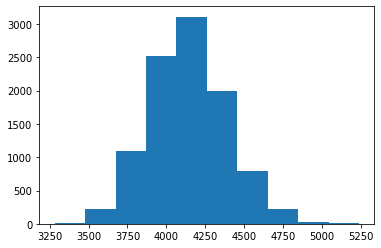

In [20]:
import matplotlib.pyplot as plt
%matplotlib inline

plt.hist(terminal_values)

In [21]:
pd.qcut(terminal_values, [0.025, 0.975])

[(3676.187, 4651.009], (3676.187, 4651.009], (3676.187, 4651.009], (3676.187, 4651.009], (3676.187, 4651.009], ..., (3676.187, 4651.009], NaN, (3676.187, 4651.009], (3676.187, 4651.009], (3676.187, 4651.009]]
Length: 10000
Categories (1, interval[float64]): [(3676.187, 4651.009]]